# datasciencing osg output pde sim

In [109]:
import sys, os, time, numpy as np, pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.ticker as mticks
import matplotlib.pyplot as plt
from scipy.special import kn
# import seaborn as sns; sns.set(color_codes=True)
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import os
%matplotlib inline
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from skimage import measure
from skimage.filters import gaussian
plt.rc('axes', linewidth=2)
#automate the boring stuff
import time, os, sys
beep = lambda x: os.system("echo -n '\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
print('notebook is at: ' + nb_dir)

from plot_for import *
sys.path.append(os.path.abspath('../pde-sim-transfer/'))
# from pde_sim_worker import *
# from pde_sim_grid_scan import *
# import test_cases

# load the autoreload extension
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2

notebook is at: /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/pde-sim/nb
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
def get_frac_matching_given_value(c0,T):
    '''gets fraction of trials that disperse for a given c0.  averages over cycles 1-7.'''
    xv = np.arange(1,8)
    yv = []
    for x in xv:
        cond = f'cycle_no=={x} and mean_c<1000 and c0=={c0} and T == {T}'
        df = df_raw.query(cond).copy()
        L = len(df['dispersedQ'].values)
        if L==0:
            pdt=0
        else:
            pdt  = 100*sum(df['dispersedQ'].values)/L
        yv.append(pdt)
    return sum(yv)/len(yv)

def fooT(df_raw, field):
    ''''''
    v_lst = list(set(df_raw[field].values))
    yv = []
    for c0 in v_lst:
        yv.append(get_frac_matching_given_value(c0,T))
    return yv

#Define list in single mobile cell
- ###TODO: plot log-log plot of k versus L for c0 = 12nM for some cycle_no
- ###TODO: calculate rate of mean_c increase for each trial.  Is it growing exponentially?  plot it on a proper log scale 
- ###TODO: logloglin surface plot of k, L, and c0.  consider coloring by one of the continuous output parameters for some cycle_no


# preprocess data

## initialize data

### import the data and compute whether dispersal has happened

In [5]:
data_dir = f"{nb_dir}/../data/"
fig_dir = f"{nb_dir}/../fig"
os.chdir(data_dir)
# data_fn = 'results_run_4.csv'
data_fn = 'results_all.csv'
df_raw = pd.read_csv(data_fn).query('mean_c<1000')#load df, ignoring any numerically unstable trials
df_raw['dispersedQ'] = (df_raw['mcd_at_100']>0) & (df_raw['mcd_at_200']>0) & (df_raw['mcd_at_300']>0)
df_raw['purely_aggregatingQ'] = (df_raw['mcd_at_100']<0) & (df_raw['mcd_at_200']<0) & (df_raw['mcd_at_300']<0)
# df_raw = df_raw.drop(columns = ['Unnamed: 0', 'index']).copy()
df_raw = df_raw.drop(columns = ['index.1', 'index']).copy()
print(df_raw.columns)

Index(['cycle_no', 'mean_c', 'mcd_at_100', 'mcd_at_200', 'mcd_at_300',
       'mcd_at_400', 'mcd_at_500', 'mcd_at_800', 'kPDE', 'LPDE', 'c0', 'T',
       'iter_no', 'dt', 'time_res', 'dispersedQ', 'purely_aggregatingQ'],
      dtype='object')


### compute rectified linear unit of mean cell direction 
(mcd_at_x00 -> relu_x00)<br>
usefule for coloration

In [6]:
print('c0 values are')
set(df_raw.c0.values)

c0 values are


{0.0, 1.0, 2.0, 3.0, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, 20.0, 30.0, 70.0}

In [7]:
# (mcd_at_x00 -> relu_x00)
rbins = [100,200,300,400, 500, 800]
for rbin in rbins:
    df_raw[f'relu_{rbin}'] = list(map(lambda x:np.max([x,0]),df_raw[f'mcd_at_{rbin}']))

### compute mean cell dispersal

In [8]:
df_raw['mcd'] = (df_raw['mcd_at_100']+df_raw['mcd_at_200']+df_raw['mcd_at_300'])/3
df_raw['relu_mcd'] = (df_raw['relu_100']+df_raw['relu_200']+df_raw['relu_300'])/3

### compute vartheta  feature

In [9]:
#first compute LcAMP
df_raw['LcAMP']    = np.sqrt(100/df_raw['kPDE'])
df_raw['vartheta'] = df_raw['LcAMP']/df_raw['LPDE']
df_raw[['vartheta','LcAMP']].describe().T

,count,mean,std,min,25%,50%,75%,max
vartheta,206303.0,38.626682,106.732515,0.01,0.545654,3.360111,20.700056,1000.0
LcAMP,206303.0,235.393798,278.667344,10.00,33.603243,112.866530,379.321621,1000.0


## compute categorical phase of cell motion near the cluster

**To Methods**
Fig. X displays three qualitatively disting phases of time-averaged cell motion, which we may numerically define as follows:

The phase is 1 if the aggregate is dispersing, is -1 if the aggregate is purely aggregating.  Otherwise, the phase 0 otherwise.

Here we consider cell motion to be in the dispersing/purely aggregating phases only when the time-averaged cell motion is directed outward/inward at all three locations probed within $300\,\mu$m from the cluster.

In [10]:
df_raw['phase'] = 0
df_raw.loc[df_raw.dispersedQ, 'phase'] = 1
df_raw.loc[df_raw.purely_aggregatingQ, 'phase'] = -1
df_raw['phase2'] = ((df_raw['phase']+1)*256/2).astype('uint8')

### compute log transformations of features

In [11]:
k_0 = 1#0.02#/sec
L_0 = 1#np.sqrt(100/k0)#microns
c_0 = 1 #nM
theta_0 = 1 #unitless
df_raw['logk'] = np.log(df_raw['kPDE']/k_0)
df_raw['logL'] = np.log(df_raw['LPDE']/L_0)
df_raw['logLcAMP'] = np.log(df_raw['LcAMP']/L_0)
df_raw['logc0']= np.log(df_raw['LPDE']/c_0)
df_raw['logtheta']= np.log(df_raw['LPDE']/theta_0)

### save df and df.description to csv

In [11]:
os.chdir(data_dir)
df_raw.to_csv(data_fn.replace('.csv','_df.csv'), index = False)
df_raw.describe().to_csv(data_fn.replace('.csv','_df_describe.csv'), index = False)

# import the preprocessing of ^that with '.csv' to '_df.csv'

In [14]:
data_dir = f"{nb_dir}/../data/"
fig_dir = f"{nb_dir}/../fig"
os.chdir(data_dir)
# data_fn = 'results_run_4.csv'
data_fn = 'results_all_df.csv'
df_raw = pd.read_csv(data_fn)#.query('mean_c<1000')#load df, ignoring any numerically unstable trials
df_raw['dispersedQ'] = (df_raw['mcd_at_100']>0) & (df_raw['mcd_at_200']>0) & (df_raw['mcd_at_300']>0)
df_raw['purely_aggregatingQ'] = (df_raw['mcd_at_100']<0) & (df_raw['mcd_at_200']<0) & (df_raw['mcd_at_300']<0)
# df_raw = df_raw.drop(columns = ['Unnamed: 0', 'index']).copy()
# df_raw = df_raw.drop(columns = ['index.1', 'index']).copy()
print(list(df_raw.columns))

['cycle_no', 'mean_c', 'mcd_at_100', 'mcd_at_200', 'mcd_at_300', 'mcd_at_400', 'mcd_at_500', 'mcd_at_800', 'kPDE', 'LPDE', 'c0', 'T', 'iter_no', 'dt', 'time_res', 'dispersedQ', 'purely_aggregatingQ', 'relu_100', 'relu_200', 'relu_300', 'relu_400', 'relu_500', 'relu_800', 'mcd', 'relu_mcd', 'LcAMP', 'vartheta', 'phase', 'phase2', 'logk', 'logL', 'logLcAMP', 'logc0', 'logtheta']


# visualize the data

## table of summary stats, removing trials with unreasonable mean_c

In [12]:
df_raw.query('c0 ==4').describe().T.head()

,count,mean,std,min,25%,50%,75%,max
cycle_no,18815.0,2.856019,2.201898,0.00000,1.00000,3.00000,5.000000,7.00000
mean_c,18815.0,-inf,NaN,-inf,3.50660,7.10371,11.795980,157.55183
mcd_at_100,18815.0,-0.338749,0.467555,-0.99123,-0.66667,-0.44375,-0.142860,0.83333
mcd_at_200,18815.0,-0.468143,0.442471,-0.98246,-0.80667,-0.62500,-0.212095,1.00000
mcd_at_300,18815.0,-0.558592,0.362555,-0.97569,-0.85526,-0.67574,-0.310065,0.99206


## remove any numerical instabilities classified by data that has unreasonably large mean_c>1000 
I remove mean_c>1000 towards the start of the nb now.

In [13]:
# cond = 'cycle_no==6 and mean_c<1000 and c0==12'

# def describe_cond(df_raw, cond):
#     s = df_raw.query(f'not ({cond})')[['kPDE','LPDE', 'c0', 'mean_c', 'dispersedQ']]
#     print(f"{len(s.mean_c.values)} trials ommited by cond = "+cond)
#     print(s.describe())
#     s = df_raw.query(cond)[['kPDE','LPDE', 'c0', 'mean_c', 'dispersedQ']]
#     print(f"\n{len(s.mean_c.values)} trials remain in this category of "+cond)
#     print(s.describe())
#     s.mean_c.hist(bins=20)
#     return s
# def count_dispersing(df):
#     return sum(df['dispersedQ'].values)
# print(f"{count_dispersing(df_raw.query(cond))} dispersing trials remain.\n")
# df = describe_cond(df_raw, cond)


# make a log log phase diagram for c0 = 12 and T = 21 and two input columns


In [14]:
#step 1: select/compute the data to be plotted
c0 = 4
T  = 21
cycle_no = 2
cond = f'cycle_no=={cycle_no} and mean_c<1000 and c0=={c0} and T=={T}'
df = df_raw.query(cond).copy()#[['kPDE','LPDE', 'c0', 'mean_c', 'dispersedQ']]
df.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
cycle_no,798.0,2.000000,0.000000,2.00000,2.00000,2.00000,2.000000,2.00000
mean_c,798.0,6.792568,4.244044,-0.00000,2.70453,8.36628,10.897343,11.21320
mcd_at_100,798.0,-0.156582,0.411792,-0.53439,-0.48677,-0.31481,-0.039682,0.79101
mcd_at_200,798.0,-0.319522,0.436712,-0.75397,-0.70106,-0.45238,0.000000,0.95238
mcd_at_300,798.0,-0.462081,0.354887,-0.84127,-0.80952,-0.54233,-0.180553,0.58201


In [15]:
# df['mcd_at_100'].describe()

## core phase diagram abstraction

In [16]:
inputs = ['T', 'c0', 'cycle_no', 'kPDE', 'LPDE', 'vartheta', 'LcAMP']
outputs = ['dispersedQ', 'mcd', 'mean_c']
print("input features are: {}".format(inputs))
print("we are interested in the response features: {}".format(outputs))

input features are: ['T', 'c0', 'cycle_no', 'kPDE', 'LPDE', 'vartheta', 'LcAMP']
we are interested in the response features: ['dispersedQ', 'mcd', 'mean_c']


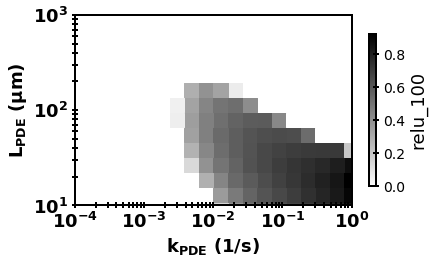

In [17]:
#step 1: select/compute the data to be plotted

#TODO: try s = c0 and c = any output
constant = {'c0':12,'T':21}

c0 = 12
T  = 21
cycle_no = 2
cond = f'cycle_no=={cycle_no} and mean_c<1000 and c0=={c0} and T=={T}'
df = df_raw.query(cond).copy()#[['kPDE','LPDE', 'c0', 'mean_c', 'dispersedQ']]
x_col = 'kPDE'
y_col = 'LPDE'
c_col = 'relu_100'

# target_lst = ['mcd_at_100']#['mean_c']#['dispersedQ']#
# c_lst = ['gray']
# s_lst = [1]#zorder
# fill_above_lst = [False]

fontsize = 18
save_fn = f'plotof_constant_c0_{c0}_T_{T}_variable_{x_col}_{y_col}_response_{c_col}.png'
# save_fn = f'plotof_constant_c0_{c0}_T_{T}_variable_{x_col}_{y_col}_response_{c_col}.png'
save_folder = f'{nb_dir}/../fig/'
cmap = plt.cm.get_cmap('gray_r')
os.chdir(save_folder)

#step 2: plot the data
#plot log scale phase diagram 
fig = plt.figure(figsize=[6.2, 3.5])#figure size
ax  = fig.add_subplot(111)

#for each target
# for target, c, s, fill_above in zip(target_lst, c_lst, s_lst, fill_above_lst):
y = df[c_col].values
X = df[[x_col, y_col]].values
im = ax.scatter(x=X[:,0],y=X[:,1], c=y, marker = 's', s=200, cmap=cmap)#plt.cm.jet)#

#color bar
cbar = fig.colorbar(im, ax=ax, shrink=0.8)#, labelsize=fontsize)
cbar.set_label(c_col, fontsize=fontsize)#, fontweight='bold')
cbar.ax.tick_params(width=2, length=6, which='both', direction='inout', labelsize=fontsize-4)
# set cbar limits as follows,
im.set_clim(df[c_col].values.min(), df[c_col].values.max())

#format plot
ax.set_xlabel('$\mathbf{k_{PDE}}$ (1/s)', fontsize=fontsize, fontweight='bold')
ax.set_ylabel('$\mathbf{L_{PDE}}$ (µm)', fontsize=fontsize, fontweight='bold')   
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([0.0001, 1, 10, 1000])
# ax.set_title('background cAMP initially = {} nM'.format(c0), fontsize=fontsize, fontweight='bold')
# make ticks big and bold
ax.tick_params(width=2, length=6, which='both', direction='inout', labelsize=fontsize)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')


# plt.show() 
# plt.close(fig)
fig.savefig(save_fn, bbox_inches ='tight', dpi = 600)

In [18]:
constant = {'c0':12,'T':21}


In [19]:
#TODO: make the abstraction
#DONE: make it greyscale
#TODO: try s = c0 and c = any output
def plot_for(df_raw,constant,x_col,y_col,c_col,s_col=None, save_dir = f'{nb_dir}/../fig/'):
    '''plot in 2D for constant-variable-response from grid search results for an abstract experiment.'''
    #step 1: select/compute the data to be plotted
    cond = f'mean_c<1000'#default conditions
    save_fn = f'plot_for constant'
    for x in list(constant):
        cond = cond + f' and {x}=={constant[x]}'#for each user defined condition
        save_fn = save_fn + f' {x}_{constant[x]}'
    df = df_raw.query(cond).copy()#[['kPDE','LPDE', 'c0', 'mean_c', 'dispersedQ']]
    save_fn = save_fn + f' variable_{x_col}_{y_col} response_{c_col}.png'
    # target_lst = ['mcd_at_100']#['mean_c']#['dispersedQ']#
    # c_lst = ['gray']
    # s_lst = [1]#zorder
    # fill_above_lst = [False]

    fontsize = 18
    save_folder = f'{nb_dir}/../fig/'
    cmap = plt.cm.get_cmap('gray_r')
    os.chdir(save_folder)

    #step 2: plot the data
    #plot log scale phase diagram 
    fig = plt.figure(figsize=[6.2, 3.5])#figure size
    ax  = fig.add_subplot(111)

    #for each target
    # for target, c, s, fill_above in zip(target_lst, c_lst, s_lst, fill_above_lst):
    y = df[c_col].values
    X = df[[x_col, y_col]].values
    im = ax.scatter(x=X[:,0],y=X[:,1], c=y, marker = 's', s=200, cmap=cmap)#plt.cm.jet)#

    #color bar
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)#, labelsize=fontsize)
    cbar.set_label(c_col, fontsize=fontsize)#, fontweight='bold')
    cbar.ax.tick_params(width=2, length=6, which='both', direction='inout', labelsize=fontsize-4)
    # set cbar limits as follows,
    im.set_clim(df[c_col].values.min(), df[c_col].values.max())

    #format plot
    # ax.set_title('background cAMP initially = {} nM'.format(c0), fontsize=fontsize, fontweight='bold')
    ax.set_xlabel('$\mathbf{k_{PDE}}$ (1/s)', fontsize=fontsize, fontweight='bold')
    ax.set_ylabel('$\mathbf{L_{PDE}}$ (µm)', fontsize=fontsize, fontweight='bold')   
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.axis([0.0001, 1, 10, 1000])
    # make ticks big and bold
    ax.tick_params(width=2, length=6, which='both', direction='inout', labelsize=fontsize)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')
    os.chdir(save_dir)    
    fig.savefig(save_fn, bbox_inches ='tight', dpi = 600)
    return fig

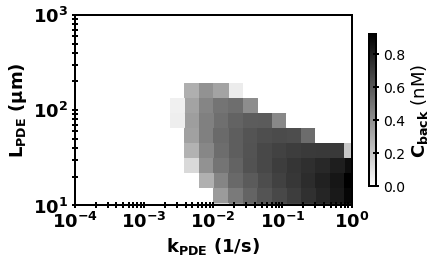

In [450]:
constant = {'c0':12,'T':21, 'cycle_no':2}
x_col = 'kPDE'
y_col = 'LPDE'
c_col = 'relu_100'
s_col = None#'vartheta'
f = plot_for(df_raw=df_raw,constant=constant,x_col=x_col,y_col=y_col,c_col=c_col)

### deprecated blendy smoothy phse diagram

In [19]:
###(deprecated) blendy smoothy phase diagram plot.  Just use the cloud to raise your resolution!
# #step 1: select/compute the data to be plotted
# c0 = 4
# T  = 21
# cycle_no = 6
# cond = f'cycle_no=={cycle_no} and mean_c<1000 and c0=={c0} and T=={T}'
# df = df_raw.query(cond).copy()#[['kPDE','LPDE', 'c0', 'mean_c', 'dispersedQ']]

# #step 2: plot the data
# save_folder = f'{nb_dir}/../fig/'
# os.chdir(save_folder)
# preamble = 'dispersal_phase_diagram'
# target_lst = ['mean_c']#['dispersedQ']#truth value to plot
# c_lst = ['gray']
# fill_above_lst = [False]
# s_lst = [1]#zorder
# fontsize = 18 
# n_neighbors = 1

# #plot log scale phase diagram 
# fig = plt.figure(figsize=[4.8, 4.8])#figure size
# ax  = fig.add_subplot(111)
# #for each target
# for target, c, s, fill_above in zip(target_lst, c_lst, s_lst, fill_above_lst):
#     #(deprecated)
#     #add that missing point on the bottom-right
#     #TODO: replace this step with a simulation result
#     #     df = add_point(df,7,1, True)   
#     y = df[target].values.astype('uint8')
#     X = df[['logk', 'logL']].values

# #     X,y = get_XY(df)
# #     X = np.array(X)
#     # we create an instance of Neighbours Classifier and fit the data.
#     h = .06#.06  # step size in the mesh
#     clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
#     clf.fit(X, y)
#     # make the decision boundary image and calculate bounding box bb. 
#     x_min, x_max = X[:, 0].min(), X[:, 0].max() 
#     y_min, y_max = X[:, 1].min(), X[:, 1].max()
#     bb = [10**x_min,10**x_max,10**y_min,10**y_max]
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                          np.arange(y_min, y_max, h))
#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

#     # calculate contours by marching squares
#     Z = Z.reshape(xx.shape)      
#     img = gaussian(Z, sigma = 2)
#     img = img/img.max()
#     contours = measure.find_contours(img, 0.5)
#     #rescale contours to data coordinates
#     pxl_y_max, pxl_x_max = img.shape
#     x_scale = lambda x_pixel: x_pixel/pxl_x_max*(x_max-x_min)+x_min
#     y_scale = lambda y_pixel: y_pixel/pxl_y_max*(y_max-y_min)+y_min
#     # Display the image and plot all contours found
#     for n, contour in enumerate(contours):
#         contour_x = 10**(x_scale(contour[:, 1]))
#         contour_y = 10**(y_scale(contour[:, 0]))
#         ax.plot(contour_x, contour_y, c = c, linewidth=4, scalex=False, scaley=False, zorder=s)
#         if fill_above:
#             y2_values = 10**5+0*contour_x
#             ax.fill_between(contour_x, contour_y,y2_values, color = c, alpha = 1, zorder = s)
#         else:
#             ax.fill(contour_x, contour_y, c = c, alpha = 1, zorder = s)
# #         ax.axis(bb)

# #format plot
# ax.set_xlabel('$\mathbf{k_{PDE}}$ (1/s)', fontsize=fontsize, fontweight='bold')
# ax.set_ylabel('$\mathbf{L_{PDE}}$ (µm)', fontsize=fontsize, fontweight='bold')   
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.axis([0.0001, .7, 10, 1000])
# ax.set_title('background cAMP = {} nM'.format(c0), fontsize=fontsize, fontweight='bold')
# #   make ticks bold
# ax.tick_params(width=2, length=5, which='both')
# for tick in ax.xaxis.get_major_ticks():
#     tick.label1.set_fontsize(fontsize)
#     tick.label1.set_fontweight('bold')
# for tick in ax.yaxis.get_major_ticks():
#     tick.label1.set_fontsize(fontsize)
#     tick.label1.set_fontweight('bold')
# ax.tick_params(axis='both', which='major', labelsize=fontsize)

# # plt.show() 
# # save_file_name= preamble+f'_Rmax_{Rmax}_c0_multiple_T_{T}_b_{b}_LR_{LR}.png'
# save_file_name = f'dpd_{int(c0)}.png'
# fig.savefig(save_file_name, bbox_inches ='tight', dpi = 600)
# # plt.close(fig)

# seaborn exploratory plots

In [20]:
# #step 1: select/compute the data to be plotted
# c0 = 4
# T  = 21
# cycle_no = 3
# cond = f'mean_c<1000 and T=={T} and cycle_no=={cycle_no}'
# # cond = f'cycle_no=={cycle_no} and mean_c<1000 and c0=={c0} and T=={T}'
# df = df_raw.query(cond).copy()#[['kPDE','LPDE', 'c0', 'mean_c', 'dispersedQ']]

# col_lst = ['logk','logL', 'c0', 'LcAMP', 'vartheta', 'mean_c', 'mcd_at_100','mcd_at_400','mcd_at_800']
# # col_lst = ['logk','logL', 'c0', 'mean_c', 'mcd_at_100','mcd_at_400','mcd_at_800', 'cycle_no']
# df[col_lst].describe().T

# #step 2: plot the data
# print(cond)
# sns.pairplot(df[col_lst], diag_kind='kde')

In [21]:
# #step 1: select/compute the data to be plotted
# c0 = 4
# T  =21
# cycle_no = 3
# cond = f'cycle_no=={cycle_no} and mean_c<1000 and c0=={c0} and T=={T}'
# df = df_raw.query(cond).copy()#[['kPDE','LPDE', 'c0', 'mean_c', 'dispersedQ']]

# col_lst = ['logk','logL', 'mean_c', 'mcd_at_100','mcd_at_400','mcd_at_800']
# df[col_lst].describe().T

# #step 2: plot the data
# print(cond)
# sns.pairplot(df[col_lst], diag_kind='kde')

# plot percent of dispersing trials for increasing cycle_no
then try other input features

In [22]:
def foo(c0,T):
    '''gets fraction of trials that disperse for a given c0'''
    xv = np.arange(0,8)
    yv = []
    for x in xv:
        cond = f'cycle_no=={x} and mean_c<1000 and c0=={c0} and T == {T}'
        df = df_raw.query(cond).copy()
        pdt  = 100*sum(df['dispersedQ'].values)/len(df['dispersedQ'].values)
        yv.append(pdt)
    return yv
    # print(f"{pdt:.2%} dispersing trials remain.\n")

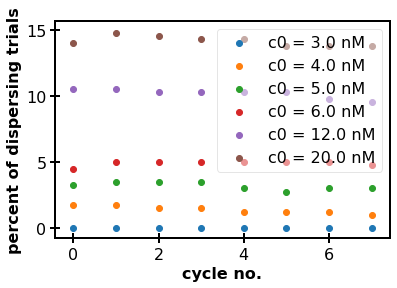

In [23]:
T = 10
save_fn = f'plot_of_cycle_no_v_percent_of_dispersing_trials_T_{T}.png'
fontsize = 16
c0v = list(set(df_raw.c0.values))
xv = np.arange(0,8)
fig, ax = plt.subplots()
os.chdir(fig_dir)
for c0 in c0v[3:-1]:
    ax.scatter(x=xv,y=foo(c0,T), label=f"c0 = {c0} nM")
ax.legend(fontsize=fontsize, fancybox = True, framealpha=0.5)
ax.set_xlabel('cycle no.', fontsize=fontsize, fontweight='bold')
ax.set_ylabel('percent of dispersing trials', fontsize=fontsize, fontweight='bold')  
ax.tick_params(width=2, length=10, which='both', direction='inout', labelsize=fontsize)
# ax.axis([0, 7, 0, 40])
fig.savefig(save_fn, bbox_inches ='tight', dpi = 600)


# TODO(repeat with results_all.csv): plot percent of dispersing trials against c0

In [141]:
#TODO: iterate through c0 and T options.  
T_list = list(set(df_raw['T'].values))
print('T options are '+  str(T_list))
print('')
c0_list = list(set(df_raw.query(f'T=={T}')['c0'].values))
print(f'c0 options given T={T} are '+ str(c0_list))
print('')
#cycle number options for a given c0 and T
cond = f'c0=={c0} and T == {T}'
tmp  = df_raw.query(cond).copy()
cycle_no_list = list(set(tmp.cycle_no.values))
print(f'cycle_no options given c0={c0} and T={T} are '+ str(c0_list))


T options are [10.0, 12.0, 16.0, 19.0, 21.0, 24.0]

c0 options given T=21 are [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 12.0, 20.0, 30.0]

cycle_no options given c0=12 and T=21 are [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 12.0, 20.0, 30.0]


#three functions solves the problem --> Query-Map-Reduce
given three input parameters as a condition, we can average over the remaining input parameters

In [142]:
#TODO: query at two stages
def foo(c0,T):
    '''for a given T and c0, reduce over each (c0,T,cycle_no) tuple to get the fraction of trials that disperse.'''
    cond = f'c0=={c0} and T == {T}'
    tmp  = df_raw.query(cond).copy()
    cycle_no_list = list(set(tmp.cycle_no.values))
    xv = cycle_no_list
    #     xv = np.arange(1,8)
    yv = []
    for x in xv:
        cond2 = f'cycle_no=={x}'
        df = tmp.query(cond2).copy()
        pdt  = 100*sum(df['dispersedQ'].values)/len(df['dispersedQ'].values)
        yv.append(pdt)
    return sum(yv)/len(yv)

def fooT(T):
    '''for a given T, reduce over each (c0,T) pair'''
    c0v = list(set(df_raw.query(f'T=={T}').c0.values))
    yv = []
    for c0 in c0v:
        yv.append(foo(c0,T))
    return yv

# def foo(c0,T):
#     '''gets fraction of trials that disperse for a given c0.  averages over cycles 1-7.'''
#     xv = np.arange(1,8)
#     yv = []
#     for x in xv:
#         cond = f'cycle_no=={x} and c0=={c0} and T == {T}'
#         df = df_raw.query(cond).copy()
#         pdt  = 100*sum(df['dispersedQ'].values)/len(df['dispersedQ'].values)
#         yv.append(pdt)
#     return sum(yv)/len(yv)

In [143]:
inputs = ['T', 'c0', 'cycle_no', 'kPDE', 'LPDE', 'vartheta', 'LcAMP']
outputs = ['dispersedQ', 'mcd', 'mean_c']
print("input features are: {}".format(inputs))
print("we are interested in the response features: {}".format(outputs))

input features are: ['T', 'c0', 'cycle_no', 'kPDE', 'LPDE', 'vartheta', 'LcAMP']
we are interested in the response features: ['dispersedQ', 'mcd', 'mean_c']


In [182]:
import matplotlib.ticker as mtick


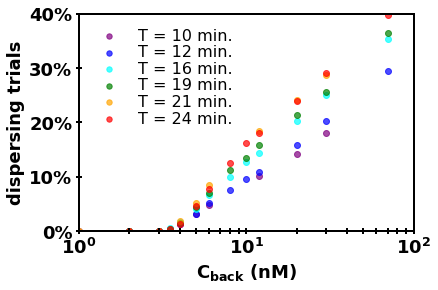

In [185]:

#step 1 calculate the data to be plotted 

#step 2 plot the results
save_fn = f'plot_of_c0_vs_percent_of_dispersing_trials.png'
fontsize = 18
T_list = list(set(df_raw['T'].values))
Tv = T_list
cv = ['purple', 'blue', 'cyan', 'green', 'orange', 'red']
fig, ax = plt.subplots(figsize=(6,4))
for T,c in zip(Tv,cv):
    c0v = list(set(df_raw.query(f'T=={T}').c0.values))
    ax.scatter(x=c0v,y=fooT(T), label=f"T = {int(T)} min.", c=c, alpha=0.7)
ax.legend(fontsize=fontsize-2, fancybox = True, framealpha=0., markerfirst=True, markerscale=0.9, labelspacing=.1)
ax.set_xlabel('$\mathbf{C_{back}}$ (nM)', fontsize=fontsize, fontweight='bold')
ax.set_ylabel('dispersing trials', fontsize=fontsize, fontweight='bold')  
# ax.tick_params(width=2, length=5, which='both', direction='inout', labelsize=fontsize)
ax.tick_params(labelsize=fontsize, length=6, width=2., which='both')
ax.axis([1, 100, 0, 40])
ax.set_xscale('log')
# ax.set_yscale('log')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

# make ticks big and bold
ax.tick_params(width=2, length=6, which='both', direction='inout', labelsize=fontsize)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')

os.chdir(fig_dir)
fig.savefig(save_fn, bbox_inches ='tight', dpi = 600)


## analyze ^this plot and get the T dependence of the slope

In [349]:
a = .4/(np.log(30)-1)
b = .28/(np.log(30)-1)
(a/24)**.5
(b/12)**.5

0.0985767423714005

In [385]:
# T=19
# (list(set(df_raw.query(f'T=={T}').c0.values))[:],fooT(T)[:])
# df_raw.groupby('T').query('')
for T in [12.0, 16.0, 19.0, 24.0]:
    print(np.max(fooT(T)))

29.453954791343207
35.44364876277909
36.52629226119576
39.68593971345797


In [386]:
# list(set(df_raw.loc[df_raw.c0>40,'T']))
ruf = pd.DataFrame({'y':[29.453954791343207,35.44364876277909,36.52629226119576,39.68593971345797],'T':[12,16,19,24]})

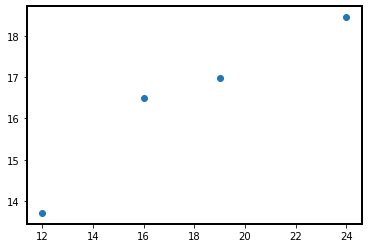

In [394]:
ruf['m'] = ruf['y']/(np.log(70/3)-1)
ruf['w'] = ruf['m']**2/ruf['T']
ruf.head()
xv = ruf["T"].values
yv = ruf.m.values
plt.scatter(x=xv, y = yv)

In [406]:
slope, intercept, r_value, p_value, std_err = stats.linregress(xv,yv)
print(f"slope dm/dT is {slope:.3f}±{std_err:.3f} (1 std_err).")
print(f"intercept T' s.t. m(T')=0 is {intercept:.3f}")
print(f"sample size N is {4:d}.")
print(f"significant p_value p = {p_value:.4f}.")
print(f"r-squared: {r_value**2:.3f}")

slope dm/dT is 0.378±0.078 (1 std_err).
intercept T' s.t. m(T')=0 is 9.706
sample size N is 4.
significant p_value p = 0.0404.
r-squared: 0.921


In [381]:
Tv = [24.0,  19.0, 16.0, 12.0]
mv = [29.027942585568788,25.627408111510352,25.10235539864592,20.23790135705942]
wv = [m**2/T for (m,T) in zip(mv,Tv)]

In [382]:
wv

[35.10922711462825, 34.56652876388982, 39.383015409995494, 34.13105427817229]

In [224]:
# df_raw['vartheta'].describe().T
from scipy import stats


In [223]:

# #step 2 plot the results
# save_fn = f'plot_of_vartheta_vs_percent_of_dispersing_trials.png'
# fontsize = 16
# T_list = list(set(df_raw['T'].values))
# Tv = T_list
# fig, ax = plt.subplots(figsize=(6,4))
# for T in Tv:
#     c0v = list(set(df_raw.query(f'T=={T}').c0.values))
#     ax.scatter(x=c0v,y=fooT(T), label=f"T = {T} min.")
# ax.legend(fontsize=fontsize, fancybox = True, framealpha=0.5)
# ax.set_xlabel('$C_{back}$ (nM)', fontsize=fontsize)#, fontweight='bold')
# ax.set_ylabel('percent of dispersing trials', fontsize=fontsize)#, fontweight='bold')  
# ax.tick_params(width=2, length=10, which='both', direction='inout', labelsize=fontsize)
# ax.axis([1, 70, 0, 40])
# ax.set_xscale('log')
# # ax.set_yscale('log')
# # os.chdir(fig_dir)
# # fig.savefig(save_fn, bbox_inches ='tight', dpi = 600)


# TODO: when does mean_c increase or decrease with cycle number?

In [83]:
groups = df_raw.groupby(inputs)

In [85]:
groups.aggregate?

notebook is at: /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/pde-sim/fig


# DONE: plot basic phase diagram ASAP

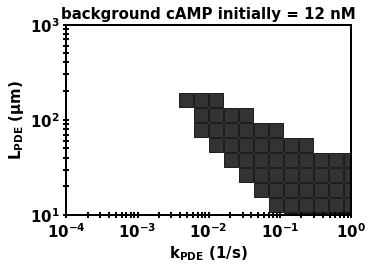

In [28]:
#step 1: select/compute the data to be plotted
c0 =12
T  = 21
cycle_no = 3
cond = f'cycle_no=={cycle_no} and mean_c<1000 and c0=={c0} and T=={T}'
df = df_raw.query(cond).copy()#[['kPDE','LPDE', 'c0', 'mean_c', 'dispersedQ']]

#step 2: plot the data
target_lst = ['dispersedQ','purely_aggregatingQ']#['mean_c']#['dispersedQ']#

n_neighbors = 2
fontsize = 15
save_fn = f'plot_KL_c0_{c0}_target_{target_lst[0]}_phase_diagram.png'
save_folder = f'{nb_dir}/../fig/'
os.chdir(save_folder)
c_lst = ['black', 'orange']
fill_above_lst = [True]
s_lst = [1]#zorder


#plot log scale phase diagram 
fig = plt.figure(figsize=[5.1, 3.5])#figure size
ax  = fig.add_subplot(111)

#for each target
for target, c, s, fill_above in zip(target_lst, c_lst, s_lst, fill_above_lst):
    df2 = df.query(target).copy()
#     y = df[target].values.astype('uint8')
    X = df2[['kPDE', 'LPDE']].values
#     Z = df[['mean_c']]
    im = ax.scatter(x=X[:,0],y=X[:,1], c=c, marker = 's', s=200, alpha=.8, )#cmap=plt.cm.jet,"Blues")
#     im = ax.scatter(x=X[:,0],y=X[:,1], c=y, marker = 's', s=200, alpha=.7, )#cmap=plt.cm.jet,"Blues")

#format plot
# cbar = fig.colorbar(im, ax=ax, shrink=0.9)#, labelsize=fontsize)
# cbar.set_label(target_lst[0], fontsize=fontsize, fontweight='bold')
ax.set_xlabel('$\mathbf{k_{PDE}}$ (1/s)', fontsize=fontsize, fontweight='bold')
ax.set_ylabel('$\mathbf{L_{PDE}}$ (µm)', fontsize=fontsize, fontweight='bold')   
ax.set_xscale('log')
ax.set_yscale('log')

ax.axis([0.0001, 1, 10, 1000])
ax.set_title('background cAMP initially = {} nM'.format(c0), fontsize=fontsize, fontweight='bold')

#   make ticks big and bold
ax.tick_params(width=2, length=6, which='both', direction='inout', labelsize=fontsize)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
# ax.tick_params(axis='both', which='major', labelsize=fontsize)
# cbar.ax.tick_params(width=2, length=10, which='both', direction='inout', labelsize=fontsize)
# cbar.tick_params(which='major', labelsize=fontsize)

#set cbar limits
# im.set_clim(0.0, 1.0)

# plt.show() 
fig.savefig(save_fn, bbox_inches ='tight', dpi = 600)
# plt.close(fig)

# plot LcAMP versus LPDE coloring by cell motion
#TODO: try s = c0 and c = any output
###TODO: Repeat phase diagram for c0 and logvartheta
#DONE: make the abstraction
#DONE: make it greyscale
#DONE: Repeat the phase diagram figure coloring by mean cell dispersal averaged over 300µm.

In [ ]:
from plot_for import *

In [54]:
print(f"all features are:\n{list(df_raw.columns)}")

all features are:
['cycle_no', 'mean_c', 'mcd_at_100', 'mcd_at_200', 'mcd_at_300', 'mcd_at_400', 'mcd_at_500', 'mcd_at_800', 'kPDE', 'LPDE', 'c0', 'T', 'iter_no', 'dt', 'time_res', 'dispersedQ', 'purely_aggregatingQ', 'relu_100', 'relu_200', 'relu_300', 'relu_400', 'relu_500', 'relu_800', 'mcd', 'relu_mcd', 'LcAMP', 'vartheta', 'phase', 'phase2', 'logk', 'logL', 'logc0', 'logtheta']


In [135]:
def my_plot_1(c0,T):
    kwargs = {'df_raw':df_raw,
          'constant':{
              'c0':0,
              'T':10, 
              'cycle_no':7},
          'x_col':'LcAMP',
          'y_col':'LPDE',
          'c_col':'relu_100',
          'x_label': '$\mathbf{L_{cAMP}}$ (µm)',
          'y_label':'$\mathbf{L_{PDE}}$ (µm)',
          'c_label':'mean cell direction',
         'axis_limits':[10**0, 10**3, 10**0, 10**3],
         's_scale':90,
          'fig_size':[4.45, 3.5],
          'c_limits':[0,1]
         }
    f = plot_for(**kwargs)
    return f

In [136]:
def my_plot_2(c0,T):
    kwargs = {'df_raw':df_raw,
              'constant':{
                  'c0':c0,
                  'T':T, 
                  'cycle_no':7},
              'x_col':'LcAMP',
              'y_col':'LPDE',
              'c_col':'mean_c',
              'x_label': '$\mathbf{L_{cAMP}}$ (µm)',
              'y_label':'$\mathbf{L_{PDE}}$ (µm)',
              'c_label':'mean cAMP (nM)',
             'axis_limits':[10**1, 10**3, 10**0, 10**3],
             's_scale':90,
              'fig_size':[4.45, 3.5],
              'c_limits':[0,20],
              'alpha':.8
             }
    f = plot_for(**kwargs)
    return f

In [137]:
Tgrid = [10,21]
c0grid = [0,4,12,30]
tmp = [(c0,T) for c0 in c0grid for T in Tgrid]
# %%time
# print(f"timing {2*len(tmp)} plots being generated...")
# for arg in tmp:
#     my_plot_1(*arg)
# #     my_plot_2(*arg)
# beep(2)

timing 16 plots being generated...
CPU times: user 42.2 s, sys: 975 ms, total: 43.2 s
Wall time: 41.3 s


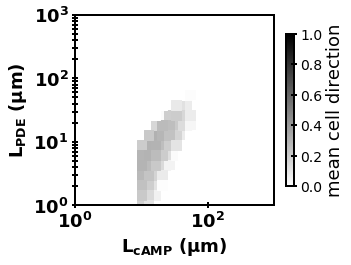

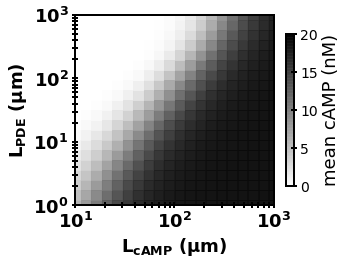

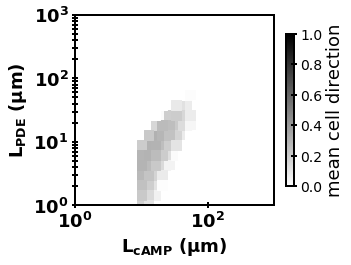

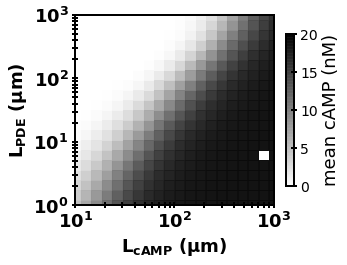

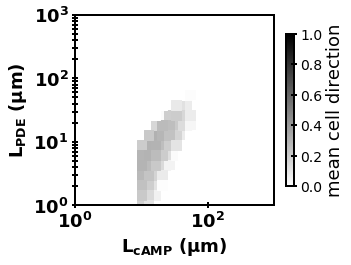

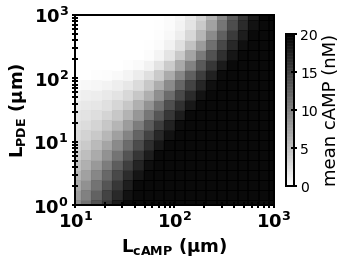

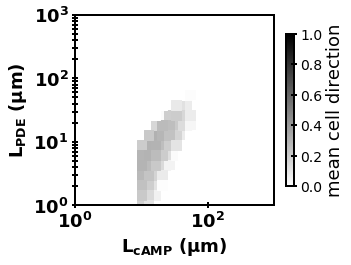

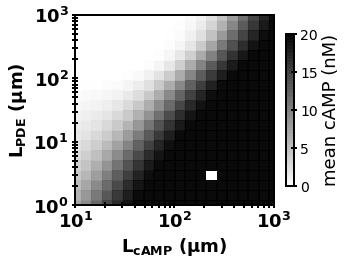

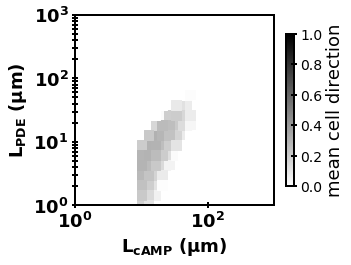

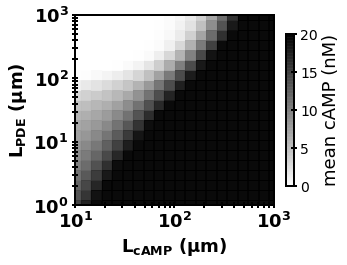

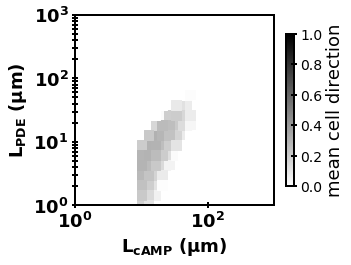

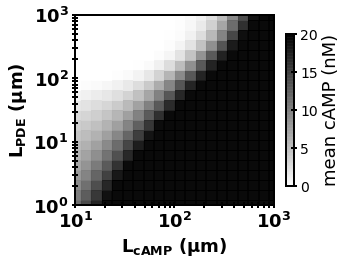

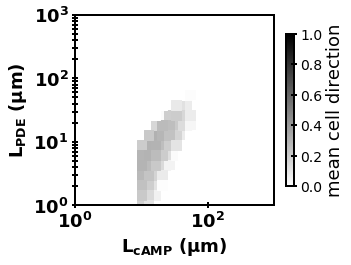

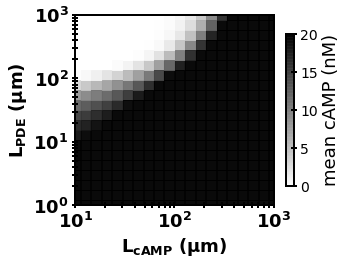

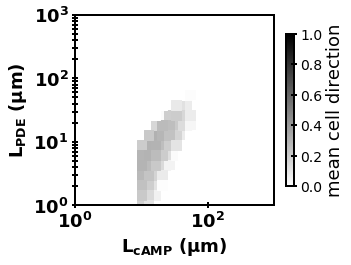

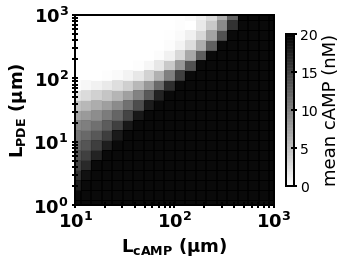

In [140]:
%%time
print(f"timing {2*len(tmp)} plots being generated...")
for arg in tmp:
    my_plot_1(*arg)
    my_plot_2(*arg)
beep(2)

# further play with plot_for()

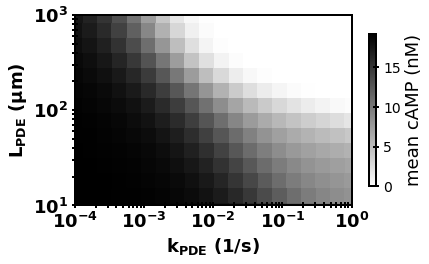

In [295]:
kwargs = {'df_raw':df_raw,
          'constant':{
              'c0':12,
              'T':21, 
              'cycle_no':2},
          'x_col':'kPDE',
          'y_col':'LPDE',
          'c_col':'mean_c',
          'c_label':'mean cAMP (nM)'}
f = plot_for(**kwargs)

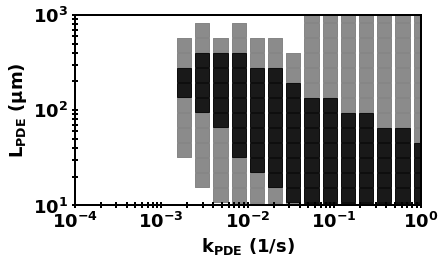

In [133]:
kwargs = {'df_raw':df_raw,
          'constant':{
              'c0':30,
              'T':21, 
              'cycle_no':2},
          'x_col':'kPDE',
          'y_col':'LPDE',
          'c_col':'phase',
          'show_cbar':False,
          'c_label':'mean cAMP (nM)',
         's_scale':200, 
         'alpha':.9,
         'figsize':[1.0, 3.5]}
f = plot_for(**kwargs)

notebook is at: /Users/timothytyree/Desktop/Research/Rappel/Dicty. Dispersal/Python/pde-sim/fig


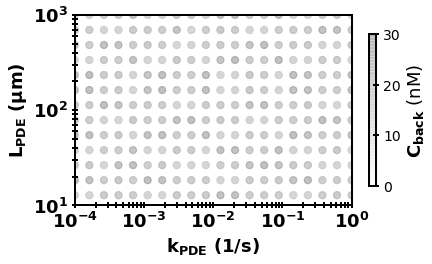

In [88]:
constant = {'T':21, 'cycle_no':2}
x_col = 'kPDE'
y_col = 'LPDE'
s_col = 'relu_200'
c_col = 'c0'
s_scale = 20
kwargs = {'df_raw':df_raw,
          'constant':{'T':21, 'cycle_no':2},
          'x_col':'kPDE','y_col':'LPDE',
          'c_col':'relu_200','c_col':'c0',
          's_scale':20, 'marker':'.', 'alpha':.1}
f = plot_for(**kwargs)

# f = plot_for(df_raw=df_raw,constant=constant,x_col=x_col,y_col=y_col,c_col=c_col, s_col=s_col, s_scale=s_scale)


# TODO(repeat with results_all.csv): make a $\mathbf{\vartheta}$ versus c0 dispersal phase diagram

In [180]:
inputs

['T', 'c0', 'cycle_no', 'kPDE', 'LPDE', 'vartheta', 'LcAMP']

In [181]:
outputs

['dispersedQ', 'mcd', 'mean_c']

In [188]:
# constant = {'T':21, 'cycle_no':2}
# x_col = 'vartheta'
# y_col = 'c0'
# c_col = 'relu_mcd'
# s_col = None#'vartheta'
# f = plot_for(df_raw=df_raw,constant=constant,x_col=x_col,y_col=y_col,c_col=c_col, axis)
k_list = list(set(df_raw.kPDE.values))
l_list = list(set(df_raw.LPDE.values))
print('kPDE options are '+  str(k_list))
print('LPDE options are '+  str(l_list))

kPDE options are [0.3792, 0.05457000000000001, 1.0, 0.6157, 0.001129, 0.0004282, 0.0001, 0.02069, 0.0002637, 0.004833, 0.0018329999999999998, 0.012740000000000001, 0.1438, 0.08856, 0.2335, 0.00785, 0.0336, 0.00016240000000000002, 0.002975, 0.000695]
LPDE options are [1.0, 1.4380000000000002, 2.977, 2.068, 4.28, 6.16, 8.86, 12.74, 18.33, 26.36, 162.4, 37.94, 54.56, 695.0, 78.5, 336.0, 483.2, 1000.0, 233.6, 112.9]


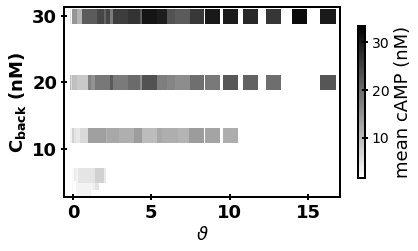

In [196]:
kwargs = {'df_raw':df_raw,
          'constant':{
              'dispersedQ':True,
#               'T':10, 
#               'kPDE':0.02069,
#               'LPDE':112.9,
              'cycle_no':5},
          'x_col':'vartheta',
          'x_label':r'$\vartheta$',
          'y_col':'c0',
          'y_label':'$\mathbf{C_{back}}$ (nM)',
          'c_col':'mean_c',
          'c_label':'mean cAMP (nM)',
          'x_log_scale':False,
          'y_log_scale':False,
          'axis_limits':None,
         }
f = plot_for(**kwargs)

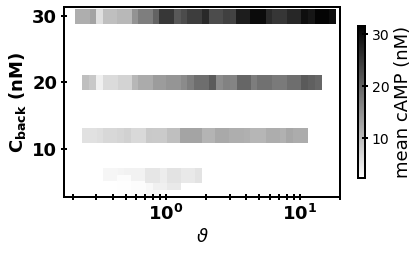

In [199]:
kwargs = {'df_raw':df_raw,
          'constant':{
              'dispersedQ':True,
              'T':21, 
              'cycle_no':2},
          'x_col':'vartheta',
          'x_label':r'$\vartheta$',
          'y_col':'c0',
          'y_label':'$\mathbf{C_{back}}$ (nM)',
          'c_col':'mean_c',
          'c_label':'mean cAMP (nM)',
          'x_log_scale':True,
          'y_log_scale':False,
          'axis_limits':None,
         }
f = plot_for(**kwargs)

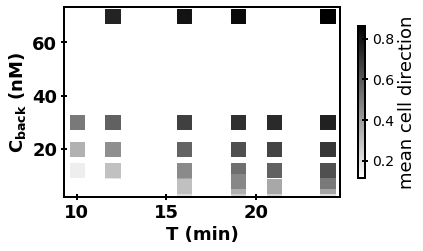

In [214]:
kwargs = {'df_raw':df_raw,
          'constant':{
              'dispersedQ':True,
              'cycle_no':2,
              'kPDE':0.02069,
              'LPDE':112.9
          },
          'y_col':'c0',
          'y_label':'$\mathbf{C_{back}}$ (nM)',
          'x_col':'T',
          'x_label':'T (min)',
          'c_col':'mcd',
          'c_label':'mean cell direction',
          'x_log_scale':False,
          'y_log_scale':False,
          'axis_limits':None,
         }
f = plot_for(**kwargs)

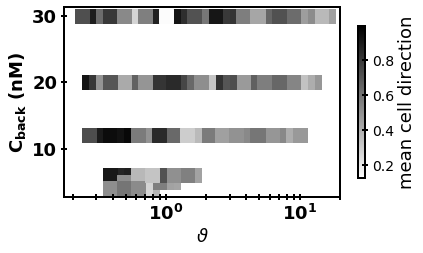

In [215]:
kwargs = {'df_raw':df_raw,
          'constant':{
              'dispersedQ':True,
              'T':21, 
              'cycle_no':2},
          'x_col':'vartheta',
          'x_label':r'$\vartheta$',
          'y_col':'c0',
          'y_label':'$\mathbf{C_{back}}$ (nM)',
          'c_col':'mcd',
          'c_label':'mean cell direction',
          'x_log_scale':True,
          'y_log_scale':False,
          'axis_limits':None,
         }
f = plot_for(**kwargs)

In [119]:
# constant = {'T':21, 'cycle_no':2}
# x_col = 'vartheta'
# y_col = 'c0'
# c_col = 'relu_mcd'
# s_col = None#'vartheta'
# f = plot_for(df_raw=df_raw,constant=constant,x_col=x_col,y_col=y_col,c_col=c_col, axis)

# TODO: abstract this 3D scatter plot into plot_for.py

To do this, color each pixel by a grayscale color and by an alpha channel.  This should create a "cloud from the cloud" visualization.

In [25]:
def plot_in_3D_for(df_raw,constant,x_col,y_col,z_col,c_col,s_col=None, save_dir = f'{nb_dir}/../fig/', marker='.'):
    '''plot in 3D for constant-variable-response from grid search results for an abstract experiment.'''
    #step 1: select/compute the data to be plotted
    cond = f'mean_c<1000 and dispersedQ'#default condition to remove bad data points
    save_fn = f'plot_in_3D_for (dispersing only) constant'
    for x in list(constant):
        cond = cond + f' and {x}=={constant[x]}'#for each user defined condition
        save_fn = save_fn + f' {x}_{constant[x]}'
    df = df_raw.query(cond).copy()#[['kPDE','LPDE', 'c0', 'mean_c', 'dispersedQ']]
    save_fn = save_fn + f' variable_{x_col}_{y_col} response_{c_col}.png'
    # target_lst = ['mcd_at_100']#['mean_c']#['dispersedQ']#
    # c_lst = ['gray']
    # s_lst = [1]#zorder
    # fill_above_lst = [False]

    fontsize = 14
    save_folder = f'{nb_dir}/../fig/'
    cmap = plt.cm.get_cmap('gray_r')
    os.chdir(save_folder)

    #step 2: plot the data
    #plot log scale phase diagram 
    fig = plt.figure()
    #figure margins
    left = -0.05; bottom = -0.05 
    width = 1.1; height = 1.1
    ax = fig.add_axes([left, bottom, width, height], projection='3d')
#     ax = fig.add_axes([left, bottom, width, height])
#     ax = fig.add_subplot(111, projection='3d')

#     fig = plt.figure(figsize=[6.2, 3.5])#figure size
#     ax  = fig.add_subplot(111)

    #for each target
    # for target, c, s, fill_above in zip(target_lst, c_lst, s_lst, fill_above_lst):
    y = df[c_col].values
    X = df[[x_col, y_col, z_col]].values
    im = ax.scatter(X[:,0],X[:,1],X[:,2], c=y, alpha=0.2, marker = marker, s=10000, cmap=cmap, edgecolors=None)#plt.cm.jet)#
#     im = ax.scatter(X[:,0],X[:,1],X[:,2], s=50, alpha=0.6, edgecolors='w')

#     #color bar
#     cbar = fig.colorbar(im, ax=ax, shrink=0.8)#, labelsize=fontsize)
#     cbar.set_label(c_col, fontsize=fontsize)#, fontweight='bold')
#     cbar.ax.tick_params(width=2, length=6, which='both', direction='inout', labelsize=fontsize-4)
#     # set cbar limits as follows,
#     im.set_clim(df[c_col].values.min(), df[c_col].values.max())
    
    #format plot
    # ax.set_title('background cAMP initially = {} nM'.format(c0), fontsize=fontsize, fontweight='bold')
    ax.set_ylabel('$\mathbf{k_{PDE}}$ (1/s)', fontsize=fontsize, fontweight='bold', 
                  position=(10,10,10))
    ax.set_xlabel('$\mathbf{L_{PDE}}$ (µm)', fontsize=fontsize, fontweight='bold')   
    ax.set_zlabel('$\mathbf{C_{back}}$ (nM)', fontsize=fontsize, fontweight='bold')   
    
    # make ticks big and bold
    ax.tick_params(width=10, length=6, which='both', direction='inout', labelsize=fontsize)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')
        d = tick
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')
    for tick in ax.zaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        tick.label1.set_fontweight('bold')
    os.chdir(save_dir)    
    fig.savefig(save_fn, bbox_inches ='tight', dpi = 600)
    return fig

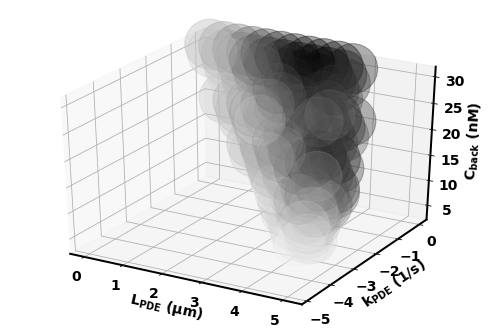

In [26]:
#TODO: make ticks thicker
#TODO: space letters out
constant = {'T':10, 'cycle_no':7}
y_col = 'logk'
x_col = 'logL'
z_col = 'c0'
c_col = 'relu_mcd'
s_col = 'relu_mcd'#'vartheta'
f = plot_in_3D_for(df_raw,constant,x_col,y_col,z_col,c_col)

In [446]:
#TODO: change the axes' margins to bring the xy tick labels in a bit.
#TODO: make ticks thicker
# ax.set_xticks
ax.get_xticks()


array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

# TODO(maybe later): make a size plot

In [ ]:
constant = {'c0':12,'T':21, 'cycle_no':2}
x_col = 'kPDE'
y_col = 'LPDE'
c_col = 'mean_c'
s_col = None#'vartheta'
f = plot_for(df_raw=df_raw,constant=constant,x_col=x_col,y_col=y_col,c_col=c_col)

In [35]:
# def plot_for(df_raw,constant,x_col,y_col,z_col,c_col,s_col=None, save_dir = f'{nb_dir}/../fig/'):
#     '''plot in 3D for constant-variable-response from grid search results for an abstract experiment.'''
#     #step 1: select/compute the data to be plotted
#     cond = f'mean_c<1000'#default condition to remove bad data points
#     save_fn = f'plot_in_3D_for constant'
#     for x in list(constant):
#         cond = cond + f' and {x}=={constant[x]}'#for each user defined condition
#         save_fn = save_fn + f' {x}_{constant[x]}'
#     df = df_raw.query(cond).copy()#[['kPDE','LPDE', 'c0', 'mean_c', 'dispersedQ']]
#     save_fn = save_fn + f' variable_{x_col}_{y_col} response_{c_col}.png'
#     # target_lst = ['mcd_at_100']#['mean_c']#['dispersedQ']#
#     # c_lst = ['gray']
#     # s_lst = [1]#zorder
#     # fill_above_lst = [False]

#     fontsize = 18
#     save_folder = f'{nb_dir}/../fig/'
#     cmap = plt.cm.get_cmap('gray_r')
#     os.chdir(save_folder)

#     #step 2: plot the data
#     #plot log scale phase diagram 
#     fig = plt.figure()
#     left = 0.05
#     bottom = 0.05 
#     width = 0.9
#     height = 0.9
#     ax = fig.add_axes([left, bottom, width, height], projection='3d')
# #     ax = fig.add_axes([left, bottom, width, height])
# #     ax = fig.add_subplot(111, projection='3d')

# #     fig = plt.figure(figsize=[6.2, 3.5])#figure size
# #     ax  = fig.add_subplot(111)

#     #for each target
#     # for target, c, s, fill_above in zip(target_lst, c_lst, s_lst, fill_above_lst):
#     y = df[c_col].values
#     X = df[[x_col, y_col, z_col]].values
#     im = ax.scatter(X[:,0],X[:,1],X[:,2], c=y, alpha=0.1, marker = 's', s=400, cmap=cmap, edgecolors=None)#plt.cm.jet)#
# #     im = ax.scatter(X[:,0],X[:,1],X[:,2], s=50, alpha=0.6, edgecolors='w')

# #     #color bar
# #     cbar = fig.colorbar(im, ax=ax, shrink=0.8)#, labelsize=fontsize)
# #     cbar.set_label(c_col, fontsize=fontsize)#, fontweight='bold')
# #     cbar.ax.tick_params(width=2, length=6, which='both', direction='inout', labelsize=fontsize-4)
# #     # set cbar limits as follows,
# #     im.set_clim(df[c_col].values.min(), df[c_col].values.max())
    
#     #format plot
#     # ax.set_title('background cAMP initially = {} nM'.format(c0), fontsize=fontsize, fontweight='bold')
#     ax.set_xlabel('$\mathbf{k_{PDE}}$ (1/s)', fontsize=fontsize, fontweight='bold')
#     ax.set_ylabel('$\mathbf{L_{PDE}}$ (µm)', fontsize=fontsize, fontweight='bold')   
#     ax.set_zlabel('$\mathbf{C_{back}}$ (nM)', fontsize=fontsize, fontweight='bold')   
    
#     # make ticks big and bold
#     ax.tick_params(width=10, length=6, which='both', direction='inout', labelsize=fontsize)
#     for tick in ax.xaxis.get_major_ticks():
#         tick.label1.set_fontsize(fontsize)
#         tick.label1.set_fontweight('bold')
#     for tick in ax.yaxis.get_major_ticks():
#         tick.label1.set_fontsize(fontsize)
#         tick.label1.set_fontweight('bold')
#     for tick in ax.zaxis.get_major_ticks():
#         tick.label1.set_fontsize(fontsize)
#         tick.label1.set_fontweight('bold')
#     os.chdir(save_dir)    
#     fig.savefig(save_fn, bbox_inches ='tight', dpi = 600)
#     return fig

# TODO(later): make a ggplot to put together four chosen plots functionally
https://matplotlib.org/gallery/style_sheets/ggplot.html#sphx-glr-gallery-style-sheets-ggplot-py

# TODO: sns.pairplot of purely aggregating collection and purely dispersing collection

**To Results:**
*We numerically studied the time-averaged radial cell motion that occurs near a circular cell aggregate that is producing pulses of chemoattractant at a regular period of $T$ minutes.  We initialized the cAMP concentration to $C_\text{back}$ uniformly everywhere, and then integrated forward in time according to Eqn. X for several cycles of duration $T$.  This serves to model the dispersal of aggregates in response to chemoattractant degradation the PDE mediates specifically near the aggregate.
<br>

In Fig. X, we considered the subset of trials ($N=400$) where $T=21$ minutes and $C_\text{back}=12$ nM and computed the average cell motion according to Eqn. Y.  Averages here were taken over time for the duration of one full period of $T = 21$ minutes

When considering 
52% trials purely aggregated with no signs of dispersal.
18% trials dispersed on average.

<br>

**To Methods:**
*We varied $k_\text{PDE},\,L_\text{PDE}$, and $C_\text{back}$ (at a resolution/scale made possible by high throughput resources) and computed 
parameter space over high-throughput resources. 
The prior category exists in the orange region of Fig. X.  208 trials purely aggregated with no signs of dispersal.

In [36]:
#load the processed data set
df_raw_fn = data_fn.replace('.csv','_df.csv')
constant = {'c0':12,'T':21, 'cycle_no':2}

x_col = 'kPDE'
y_col = 'LPDE'
c_col = 'mcd'
s_col = None#c0#'vartheta'
c_label = 'MCD'
f = plot_for(df_raw=df_raw,constant=constant,x_col=x_col,y_col=y_col,c_col=c_col, c_label = c_label)

TypeError: plot_for() got an unexpected keyword argument 'c_label'

In [ ]:
ain = ['kPDE','LPDE','vartheta','LcAMP']
aout = ['dispersedQ', 'mcd', 'mean_c']
columns = ain + aout

cond = f'mean_c<1000'#default conditions
save_fn = f'plot_for sns'
for x in list(constant):
    cond = cond + f' and {x}=={constant[x]}'#for each user defined condition
    save_fn = save_fn + f' {x}_{constant[x]}'
df = df_raw.query(cond).copy()#[['kPDE','LPDE', 'c0', 'mean_c', 'dispersedQ']]



In [ ]:
print("{:.0%} trials purely aggregated with no signs of dispersal.".format(df['purely_aggregatingQ'].sum()/len(list(df.dispersedQ.values))))
print("{:.0%} trials dispersed on average.".format(df['dispersedQ'].sum()/len(list(df.dispersedQ.values))))
print("this is for {} trials considered in total.".format(len(list(df.dispersedQ.values))))
print(f"constants are {constant}.")
# df.describe().T

In [ ]:
# set_1 = df.query('dispersedQ')
# set_2 = df.query('purely_aggregatingQ')

In [ ]:
##step 0: see if a comparison figure matters using sns.pairplot()
import seaborn as sns

In [ ]:
# sns.pairplot(df[columns], hue=list(df["phase"].values))
sns.pairplot?

In [ ]:
print("^that was dispersing.  the following is purely aggregating:")
sns.pairplot(df[columns], hue='p')

In [ ]:
sns.pair

# TODO: take that (c0,T) grid search from the cloud and make a plot of percent of trials that support dispersal versus c0 on the xaxis.  Plot for each T for all trials performed.

# TODO: plot dispersing trials against c0 and $\vartheta$ for some cycle_no and each T

# scratchwork to speed up Hill degradation using preevaluation using numpy signatures
#current wall time 4ms
#target wall time 2ms

In [3]:
@np.vectorize
def get_Hill_degradation_term_old(kPDE,c,b,h,pde):
	'''let overall scale of degradation still vary as kPDE.'''
	return -kPDE*np.divide(np.multiply(pde,c**(h-1.)),(b**h+c**h)) if c>0 else 0	

In [4]:
#test case for hill degradation term
rmesh = np.arange(50,1000,1).astype('float64')
h=0.8; c = np.arange(50,1000,1).astype('float64'); b = 0.75; kPDE=.1
assert(len(list(get_Hill_degradation_term_old(1.,c,1.,1.,c)))==len(list(c)))

In [5]:
%%time
retval = get_Hill_degradation_term_old(1,c,1,1,c)

CPU times: user 3.44 ms, sys: 24 µs, total: 3.46 ms
Wall time: 3.45 ms


In [6]:
# %%time
# retval = get_Hill_degradation_term(c,c,1,1,1)

In [43]:
# @np.vectorize
def get_Hill_degradation_term(c,pde,kPDE,b,h):
    '''let overall scale of degradation still vary as kPDE.'''
#     return -kPDE*np.divide(np.multiply(pde,c**(h-1.)),(b**h+c**h)) if c>0 else 0
    boo = c>0
    out = 0*c
    out[boo] = -kPDE*np.divide(np.multiply(pde[boo],c[boo]**(h-1.)),(b**h+c[boo]**h))
    return out

# initialize with numpy signatures to speed up to about twice the previous run time (original mode==0 case) 
mesh_size = len(rmesh)
degrade = np.vectorize(lambda c,pde:get_Hill_degradation_term(c,pde,kPDE=kPDE,b=b,h=h),
    signature = f"({mesh_size}),({mesh_size})->({mesh_size})")

    
# initialize with numpy signatures
mesh_size = len(rmesh)
degrade = np.vectorize(lambda c,pde:get_Hill_degradation_term(c,pde,kPDE=kPDE,b=b,h=h),signature = f"({mesh_size}),({mesh_size})->({mesh_size})")


In [44]:
%%time
for i in range(100):
    retval = degrade(c,c)

CPU times: user 15.3 ms, sys: 958 µs, total: 16.3 ms
Wall time: 15.4 ms


In [20]:
mesh_size = len(rmesh)
@np.vectorize
def get_Hill_degradation_term(c,pde,kPDE,b,h):
    '''let overall scale of degradation still vary as kPDE.'''
#     return -kPDE*np.divide(np.multiply(pde,c**(h-1.)),(b**h+c**h)) if c>0 else 0
    boo = c>0
    out = 0*c
    out[boo] = -kPDE*np.divide(np.multiply(pde[boo],c[boo]**(h-1.)),(b**h+c[boo]**h))
    return out
# get_Hill_degradation_term.signature = f"({mesh_size}),({mesh_size})->({mesh_size})"

# initialize with numpy signatures
# degrade = np.vectorize(lambda c,pde:get_Hill_degradation_term(c,pde,kPDE=kPDE,b=b,h=h),

NameError: name 'rmesh' is not defined

In [ ]:
%%time
for i in range(100):
    retval = get_Hill_degradation_term(c,c,kPDE,b,h)

# Fig. 3B Phase diagram plot

In [29]:
from plot_for import *

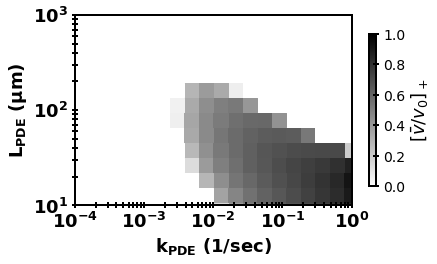

In [171]:
c0 = 12
T  = 21
kwargs = {'df_raw':df_raw,
          'constant':{
              'c0':c0,
              'T':T, 
              'cycle_no':2},
          'x_col':'kPDE',
          'y_col':'LPDE',
          'c_col':'relu_100',
              'x_label': '$\mathbf{k_{PDE}}$ (1/sec)',
          'y_label':'$\mathbf{L_{PDE}}$ (µm)',
          'c_label':r'$[\bar{v}/v_0]_+$',
#           'c_label':'outward fraction of cell motion at 200 µm',
#          'axis_limits':[10**1, 10**3, 10**0, 10**3],
#          's_scale':90,
#           'fig_size':[4.45, 3.5],
          'c_limits':[0,1],
#           'alpha':.8
         }
f = plot_for(**kwargs)

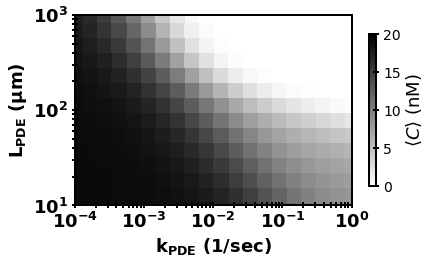

In [176]:
c0 = 12
T  = 21
kwargs = {'df_raw':df_raw,
          'constant':{
              'c0':c0,
              'T':T, 
              'cycle_no':2},
          'x_col':'kPDE',
          'y_col':'LPDE',
          'c_col':'mean_c',
              'x_label': '$\mathbf{k_{PDE}}$ (1/sec)',
          'y_label':'$\mathbf{L_{PDE}}$ (µm)',
          'c_label':r'$\langle C \rangle$ (nM)',
#           'c_label':'outward fraction of cell motion at 200 µm',
#          'axis_limits':[10**1, 10**3, 10**0, 10**3],
#          's_scale':90,
#           'fig_size':[4.45, 3.5],
          'c_limits':[0,20],
#           'alpha':.8
         }
f = plot_for(**kwargs)

In [47]:
# df_raw.columns
df_raw[['phase', 'phase2']].describe().T

,count,mean,std,min,25%,50%,75%,max
phase,206303.0,-0.571756,0.638386,-1.0,-1.0,-1.0,0.0,1.0
phase2,206303.0,33.991789,56.528955,0.0,0.0,0.0,128.0,128.0


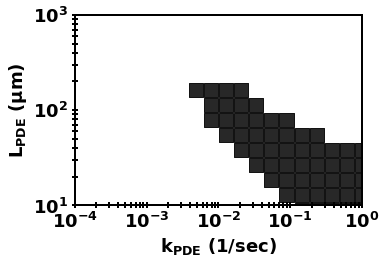

In [134]:
c0 = 12
T  = 21
kwargs = {'df_raw':df_raw,
          'constant':{
              'c0':c0,
              'T':T, 
              'cycle_no':2},
          'x_col':'kPDE',
          'y_col':'LPDE',
          'c_col':'dispersedQ',
              'x_label': '$\mathbf{k_{PDE}}$ (1/sec)',
          'y_label':'$\mathbf{L_{PDE}}$ (µm)',
          'c_label':r'$\langle v \rangle_{time} \bar{v}$',
#           'c_label':'outward fraction of cell motion at 200 µm',
#          'axis_limits':[10**1, 10**3, 10**0, 10**3],
         's_scale':200,
          'fig_size' : [5.15, 3.5],
#           'fig_size':[4.45, 3.5],
          'c_limits':[0,1],
          'alpha':.6,
          'show_cbar':False,
          'save_folder': f'{nb_dir}/../',
          'edgecolors':'face'
         }
f = plot_for(**kwargs)

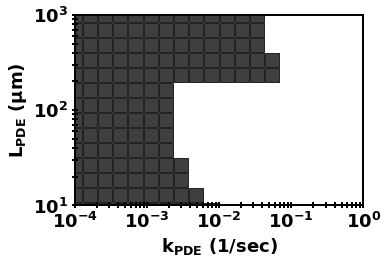

In [111]:
c0 = 12
T  = 21
kwargs = {'df_raw':df_raw,
          'constant':{
              'c0':c0,
              'T':T, 
              'cycle_no':7},
          'x_col':'kPDE',
          'y_col':'LPDE',
          'c_col':'purely_aggregatingQ',
              'x_label': '$\mathbf{k_{PDE}}$ (1/sec)',
          'y_label':'$\mathbf{L_{PDE}}$ (µm)',
          'c_label':r'$\langle v \rangle_{time} \bar{v}$',
#           'c_label':'outward fraction of cell motion at 200 µm',
#          'axis_limits':[10**1, 10**3, 10**0, 10**3],
#          's_scale':90,
          'fig_size' : [5.17, 3.5],
#           'fig_size':[4.45, 3.5],
          'c_limits':[0,1],
          'alpha':.5,
          'show_cbar':False
         }
f = plot_for(**kwargs)

In [173]:
def my_plotty(T):
    df_raw.sort_values(by='c0', inplace=True,ascending=True)
    kwargs = {'df_raw':df_raw,
              'constant':{
                  'T':T, 
                  'cycle_no':2},
              'x_col':'kPDE',
              'y_col':'LPDE',
              'c_col':'dispersedQ',
    #           'c_col':'relu_200',
              's_col':'c0',
              'x_label': '$\mathbf{k_{PDE}}$ (1/sec)',
              'y_label':'$\mathbf{L_{PDE}}$ (µm)',
              'c_label':r'$$',
    #           'c_label':'outward fraction of cell motion at 200 µm',
    #          'axis_limits':[10**1, 10**3, 10**0, 10**3],
             's_scale':26,
              'fig_size' : [5.17, 3.5],
    #           'fig_size':[4.45, 3.5],
              'c_limits':[0,1],
              'marker':'.',
              'alpha':.1,
              'show_cbar':False
             }
    f = plot_for(**kwargs)
    return f

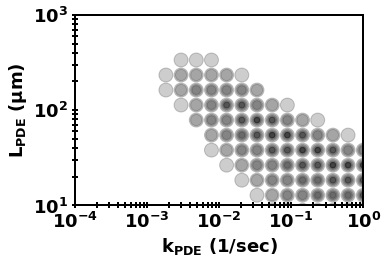

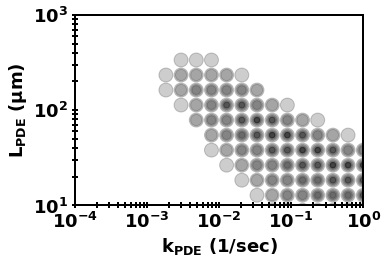

In [175]:
my_plotty(21)

In [113]:
Tgrid = [10,21]
c0grid = [0,4,12,30]
tmp = [(c0,T) for c0 in c0grid for T in Tgrid]

timing 16 plots being generated...
CPU times: user 32.2 s, sys: 819 ms, total: 33 s
Wall time: 32.3 s


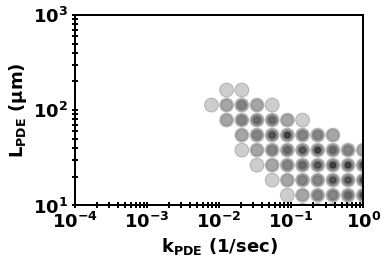

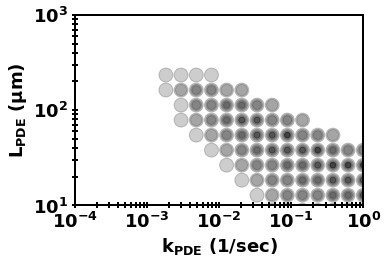

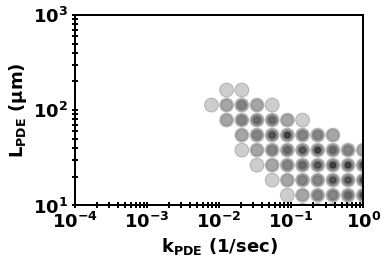

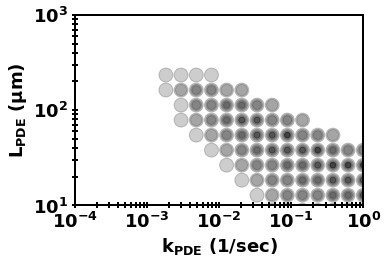

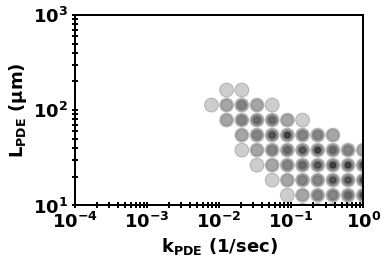

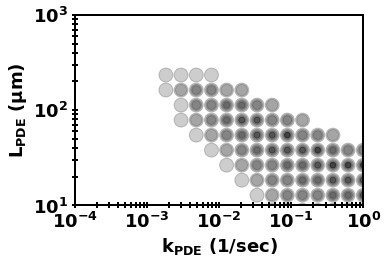

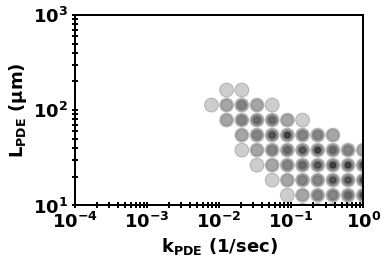

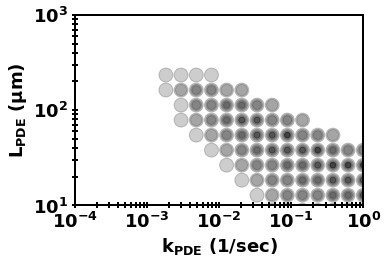

In [114]:
%%time
print(f"timing {2*len(tmp)} plots being generated...")
for arg in tmp:
    my_plotty(*arg)
beep(2)

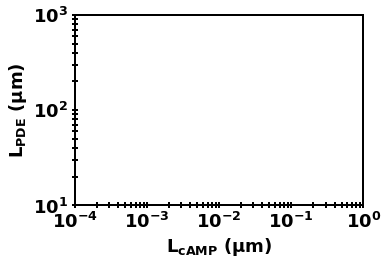

In [117]:
    df_raw.sort_values(by='c0', inplace=True,ascending=True)
    kwargs = {'df_raw':df_raw,
              'constant':{
                  'T':T, 
                  'cycle_no':7},
              'x_col':'LcAMP',
              'y_col':'LPDE',
              'c_col':'dispersedQ',
    #           'c_col':'relu_200',
              's_col':'c0',
              'x_label': '$\mathbf{L_{cAMP}}$ (µm)',
              'y_label':'$\mathbf{L_{PDE}}$ (µm)',
#               'c_label':r'$$',
    #           'c_label':'outward fraction of cell motion at 200 µm',
    #          'axis_limits':[10**1, 10**3, 10**0, 10**3],
             's_scale':26,
              'fig_size' : [5.17, 3.5],
    #           'fig_size':[4.45, 3.5],
              'c_limits':[0,1],
              'marker':'.',
              'alpha':.1,
              'show_cbar':False
             }
    f = plot_for(**kwargs)

# make Fig. X for the paper
dispersing trials on y axis 
cbac on x axis 
T=21=constant

In [55]:
T = 21
# c0 =
# T_list = list(set(df_raw['T'].values))
# print('T options are '+  str(T_list))
# print('')
# c0_list = list(set(df_raw.query(f'T=={T}')['c0'].values))
# print(f'c0 options given T={T} are '+ str(c0_list))
# cond = f'c0=={c0} and T == {T}'
# cond = f'T == {T}'

# print('')
#cycle number options for a given c0 and T
cond = f'T == {T}'
tmp  = df_raw.query(cond).copy()
cycle_no_list = list(set(tmp.cycle_no.values))
# print(f'cycle_no options given c0={c0} and T={T} are '+ str(c0_list))


In [83]:
# df_raw.columns
df = df_raw.query(f"T=={T} and c0 =={12}")['dispersedQ'].mean()
df

0.185

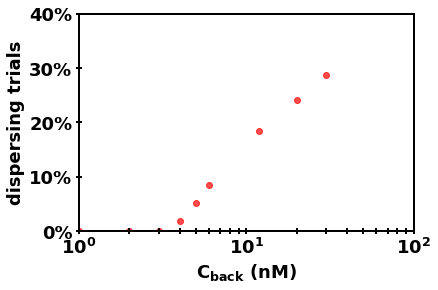

In [111]:
#step 1 calculate the data to be plotted 
T = 21
x_values = np.array(list(set(df_raw.query(f'T=={T}')['c0'].values)))
y_values = 100*np.array([        df_raw.query(f"T=={T} and c0 =={c0}")['dispersedQ'].mean() for c0 in x_values])
            
# c0_list  = list(set(df_raw.query(f'T=={T}')['c0'].values))
# y_values /= get_frac_matching_given_value(c0_list,T)
# x_values = 

#step 2 plot the results
save_fn = f'Fig_sx.png'
fontsize = 18
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x=x_values,y=y_values, label=f"T = {int(T)} min.", c='r', alpha=0.7)
# ax.legend(fontsize=fontsize-2, fancybox = True, framealpha=0., markerfirst=True, markerscale=0.9, labelspacing=.1)
ax.set_xlabel('$\mathbf{C_{back}}$ (nM)', fontsize=fontsize, fontweight='bold')
ax.set_ylabel('dispersing trials', fontsize=fontsize, fontweight='bold')  
# ax.tick_params(width=2, length=5, which='both', direction='inout', labelsize=fontsize)
ax.tick_params(labelsize=fontsize, length=6, width=2., which='both')
ax.axis([1, 100, 0, 40])
ax.set_xscale('log')
# ax.set_yscale('log')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(xticks)

# make ticks big and bold
ax.tick_params(width=2, length=6, which='both', direction='inout', labelsize=fontsize)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
#     tick.label1.set_label(f'{tick.label1.get_label()}%%')

os.chdir(fig_dir)
fig.savefig(save_fn, bbox_inches ='tight', dpi = 600)


In [110]:
save_fn

'Fig_sx.pdf'